# Checkpoint 3: Variational Autoencoder & Generative and adversarial models
---
*Responsible:* Guillermo Hamity (<ghamity@ed.ac.uk>)


Quickdraw was an interesting dataset but requires quite a lot of CPU to get decent results. We discussed a relatively good solution to the problem in the Lecture, but it is quite CPU intensive.

In order to make life a little easier in terms of training time, in this checkpoint exercise we will work with the MNIST dataset of hand-written digits. This time, though, we won't be classifying existing images, we will be generating new ones with generative models. 

- Exersice 1 and 2 we will build and use a Variational Autoencoder
- Exersice 3 we will use a Generative Adeverserial Network


These exercises build quite heavily on the ones in CP2. The network structure that worked on quickdraw should translate pretty well to MNIST, and hopefully perform better. You may be able to reuse some of your work, or you can look at my proposed solutions from last time for inspiration.


### Notes on assessment
* Try and calculate the answers to the exercises provided. If you are unable to complete the question, describe which approach you _would_ have taken to solve the problem
* Code must be understandable and reproducible. Before grading the notebook kernel **may** be restarted and re-run, so make sure that your code can run from start to finish without any (unintentional) errors
* If you are unsure on how to proceed please **ask one of the TAs** during the workshop
- Notebooks should be submitted by **10am on Friday 29 November 2020** 
- This CP exercise sheet is divided into **3 sections** giving a maximum of **10 marks** in total:

| <p align='left'> Title                        | <p align='left'> Exercise nos. | <p align='center'> Number of marks |
| ------------------------------------------------------ | --------------------- | ------------------ |
| <p align='left'> 1. Build VAE                          | <p align='left'> 1–3  | <p align='left'> 4 |
| <p align='left'> 2. Compile and train a VAE            | <p align='left'> 4–6  | <p align='left'> 4 | 
| <p align='left'> 3. Generative adversarial network     | <p align='left'> 7–9  | <p align='left'> 2 |
| <p align='left'> **Total**                             |                       | <p align='left'> **10** |

## Preamble
---

In [3]:
# Standard import(s)
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [22]:
# Keras import(s)
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.layers import Input, Dense, Dropout, Flatten, Reshape, Conv2D, Conv2DTranspose, Concatenate, Lambda,BatchNormalization, UpSampling2D, MaxPooling2D
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.losses import binary_crossentropy
from tensorflow.python.keras.layers.advanced_activations import LeakyReLU
from tensorflow.python.keras.backend import set_image_data_format
from tensorflow.keras.optimizers import Adam
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()
set_image_data_format('channels_last')  # Images are formatted as (N, N, 1), with colour-channels last



## Data preprocessing
---

First, we'll load in the MNIST dataset from TensorFlow, which has already been split into training and testing parts for us.

In [5]:
# Load in MNIST dataset 
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

# Get numbers
nb_train   = X_train.shape[0]
nb_test    = X_test .shape[0]
nb_classes = y_train.max() + 1
print(f"Number of training examples: {nb_train}")
print(f"Number of testing  examples: {nb_test}")
print(f"Number of target classes:    {nb_classes}")

# Reshape inputs to (N,N,1), i.e. have one colour dimension
X_train = X_train[..., np.newaxis]
X_test  = X_test [..., np.newaxis]

# Standardise inputs
print("Max. input before scaling: {}".format(X_train.max()))
X_train = X_train / 255.
X_test  = X_test  / 255.

# Get image shape
shape = X_train.shape[1:]
print(f"Image shape:  {shape}")

# Shuffle (dataset is pre-shuffled, but still)
ix_train = np.random.permutation(nb_train)
ix_test  = np.random.permutation(nb_test)

X_train = X_train[ix_train]
y_train = y_train[ix_train]

X_test  = X_test [ix_test]
y_test  = y_test [ix_test]


11493376/11490434 [==============================] - 0s 0us/step
Number of training examples: 60000
Number of testing  examples: 10000
Number of target classes:    10
Max. input before scaling: 255
Image shape:  (28, 28, 1)


The image below shows labels and images associated to them. They are in our standard (28,28,1) image format, as we had in quickdraw.

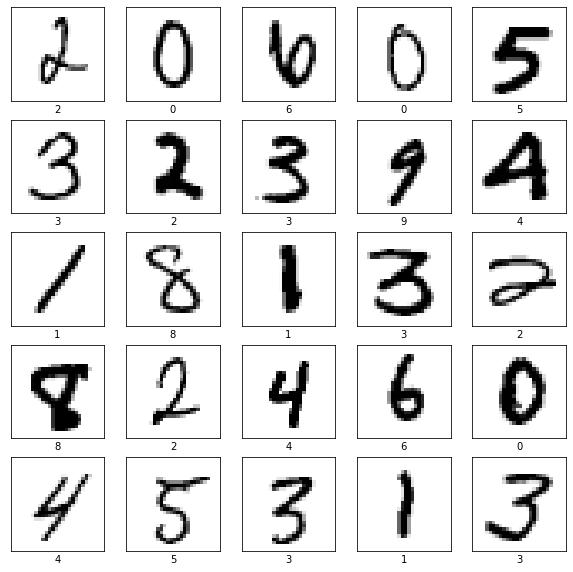

label marks [2 0 6 0 5 3 2 3 9 4 1 8 1 3 2 8 2 4 6 0 4 5 3 1 3]


In [73]:
nb_show = 25
plt.figure(figsize=(10,10))
for i in range(nb_show):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.xlabel(y_train[i])
plt.show()
print("label marks",y_train[:nb_show])

## Variational auto-encoder (VAE) utilities
---
Below, I am providing you with some utility methods for training VAEs. This is done to minimsie the overhead in getting you up and running and training cool neural networks.

The first function implements the crucial element for _variational_ auto-encoders: The random sampling in the latent space. The `sampling` function below takes one argument, which is assumed to be a list with two element: the means and the logarithm of the variances, respectively, of the latent probability density function (p.d.f.) for a given image example. The function then samples random numbers, and scales them such that they are effectively drawn from a p.d.f. with means and standard deviations as given by `args`. These sampled coordinates in the latent space are then returned.

In [59]:
def sampling (args):

  # Unpack arguments
  z_mean, z_log_var = args

  # Get shape of random noise to sample
  epsilon = K.random_normal(shape=K.shape(z_mean))

  # Return samples from latent space p.d.f.
  return z_mean + K.exp(0.5 * z_log_var) * epsilon

# Build a VAE (4 marks)

#### 1. Build the encoder of the VAE (1.5 mark)

Build an encoder. We will train for 50 epoches so a relatively fast NN may be desiriable. Here you have some freedom but some example structure is given:
- the input layer has the dimension of the shape
- Flat the input layer (either with or without convolution beforehand)
    - The `1 2 4 8 16` convolution example worked well for me, but is a bit slower.
- add a few hidden Dense layer (with relu activation function) with 256 dimension of hidden nodes
- Add the 2 special layers:
    * `z_mean` contains the means of the latent space p.d.f. for a given image, and
    * `z_log_var` contains the logarithm of the assocated variances. 
- Pass these 2 layers into a layer `z` that just apply the `sampling` method above. Note: the sampling method is used to perform the reparametrization trick. `Lambda` has to be used to ensure the gradients to be computed (see Lecture example) 
- Output the 3 layers (z_mean, z_log_var and z)
- build the encoder model with the `Model` method. 
    - If you used convolution and pooling make sure you complient this with Upsampleling and ConvolutionTranspose. 
    - A good structure here is to invert the stucture of the encoder, e.g. `16 8 4 2 1`.

In [159]:
intermediate_dim =256
latent_dim = 2

# Define the encoder

# Shape was defined earlier in the program as (28,28,1), which is what we want
i = Input(shape = shape)
x = Conv2D(1, kernel_size=(3,3), padding='same', activation='relu')(i)
x = MaxPooling2D((2,2), padding = 'same')(x)
x = Conv2D(2, kernel_size=(3,3), padding='same', activation='relu')(x)
x = Conv2D(4, kernel_size=(3,3), padding='same', activation='relu')(x)
x = MaxPooling2D((2,2), padding = 'same')(x)
x = Conv2D(8, kernel_size=(3,3), padding='same', activation='relu')(x)
x = Conv2D(16, kernel_size=(3,3), padding='same', activation='relu')(x)
e = Flatten()(x)
hidden0 = Dense(intermediate_dim,activation = 'relu')(e)
hidden1 = Dense(intermediate_dim,activation = 'relu')(hidden0)
# z_mean, z_log_var and z layers
z_mean = Dense(latent_dim, name='z_mean')(hidden1)
z_log_var = Dense(latent_dim, name='z_log_var')(hidden1)
z = Lambda(sampling, output_shape=(latent_dim,),name='z')([z_mean,z_log_var])

# Model
encoder = Model(i,[z_mean, z_log_var, z], name='encoder')

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_44 (InputLayer)           [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_149 (Conv2D)             (None, 28, 28, 1)    10          input_44[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_12 (MaxPooling2D) (None, 14, 14, 1)    0           conv2d_149[0][0]                 
__________________________________________________________________________________________________
conv2d_150 (Conv2D)             (None, 14, 14, 2)    20          max_pooling2d_12[0][0]           
____________________________________________________________________________________________

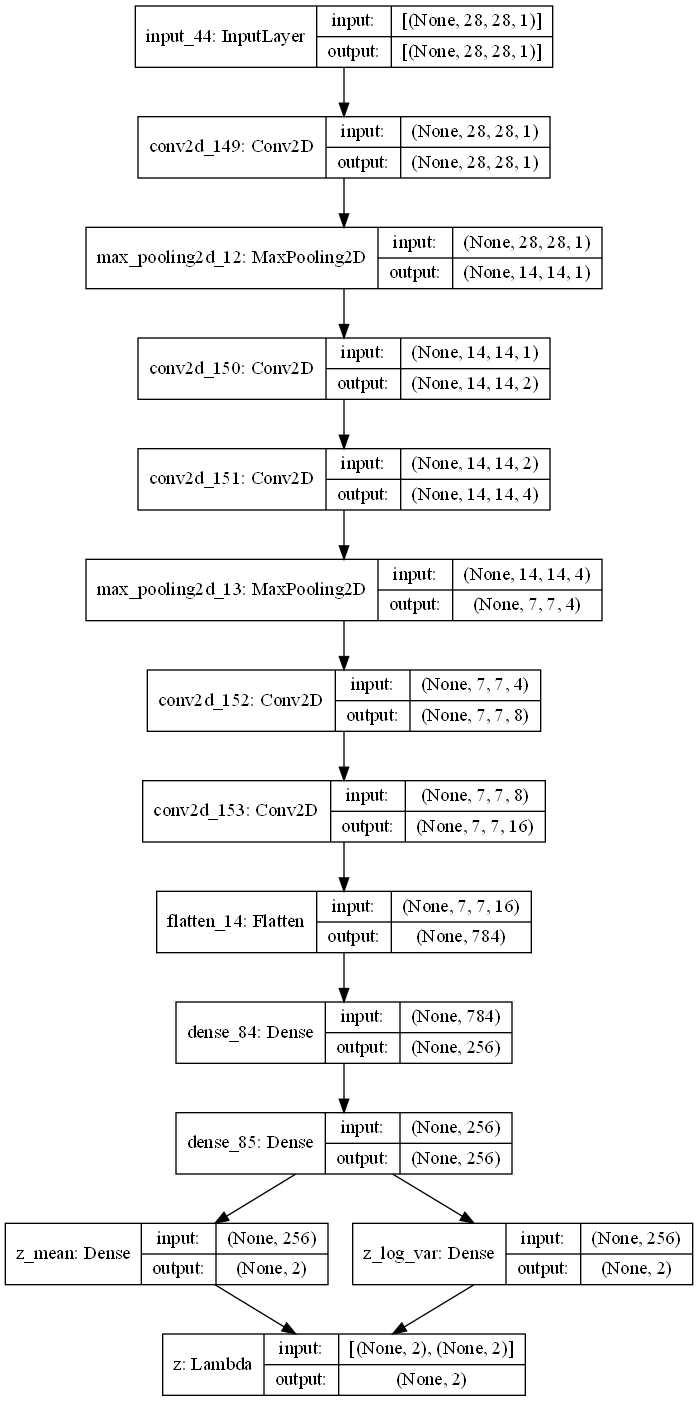

In [160]:
# Visualise the encoder
encoder.summary()
plot_model(encoder,show_shapes = True)

#### 2. Build the decoder of the VAE (1.5 mark)

Build a decoder:
- the input layer has the latent space 2
- Apply 2 hidden Dense layers with dimension 256 (same number as in the encoder) and relu activation function
- Output sigmoid activation function such that it ends up with the same shape as the original image, with pixel intensities in the range $[0, 1]$.
    - use as dimension of this layer `np.prod(shape)`, where shape is the latent space.
- then reshape the output to the original image shape with `Reshape` method. This step is needed to bring back the data from shape (latent_dim, ) into some shape that can be reshaped into the output shape of the last layer of our encoder.
- build the decoder model with the `Model` method

In [161]:
print(np.prod(shape))

784


In [162]:
# Construct the decoder

# latent space of two for input layer, same as latent_dim
dec_i = Input(shape = (latent_dim,))
y = Dense(intermediate_dim,activation = 'relu')(dec_i)
# 784 as previous flatten brings it to 784. maybe introduce another dense layer with 256 nodes
y = Dense(7*7*16,activation = 'relu')(y)
# Reshape. Comes after in the instructions above, which I sort of understand but why not put it here?
y = Reshape((7,7,16))(y)
y = Conv2D(16, (3,3), activation = 'relu', padding = 'same')(y)
y = Conv2D(8, (3,3), activation = 'relu', padding = 'same')(y)
y = UpSampling2D(size = (2,2))(y)
y = Conv2D(4, (3,3), activation = 'relu', padding = 'same')(y)
y = Conv2D(2, (3,3), activation = 'relu', padding = 'same')(y)
y = UpSampling2D(size = (2,2))(y)
o = Conv2D(1, (3,3), activation = 'sigmoid', padding = 'same')(y)

# Model
decoder = Model(dec_i, o, name = 'decoder')

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_45 (InputLayer)        [(None, 2)]               0         
_________________________________________________________________
dense_86 (Dense)             (None, 256)               768       
_________________________________________________________________
dense_87 (Dense)             (None, 784)               201488    
_________________________________________________________________
reshape_19 (Reshape)         (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_154 (Conv2D)          (None, 7, 7, 16)          2320      
_________________________________________________________________
conv2d_155 (Conv2D)          (None, 7, 7, 8)           1160      
_________________________________________________________________
up_sampling2d_37 (UpSampling (None, 14, 14, 8)         0   

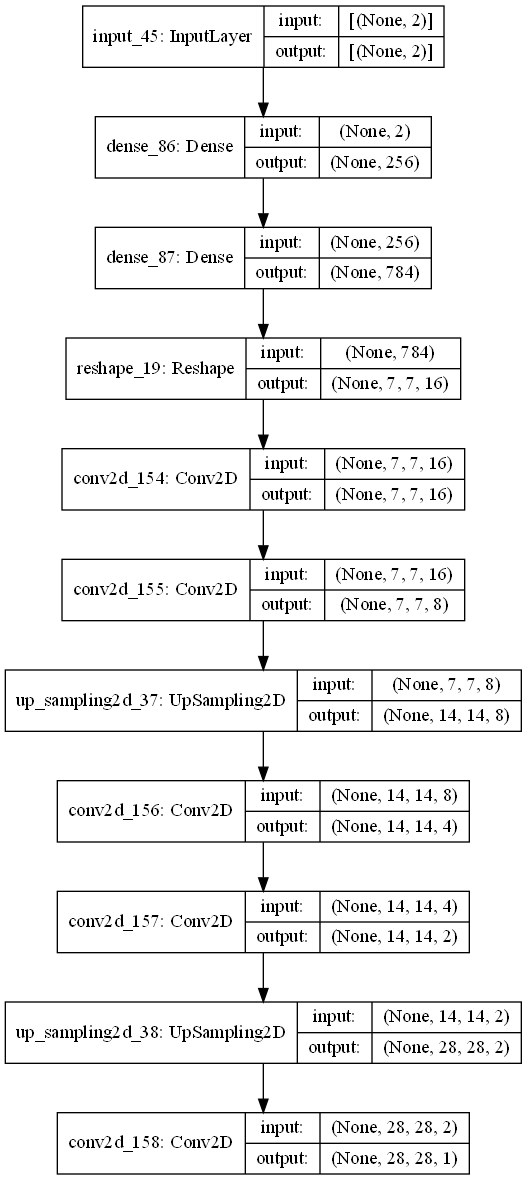

In [163]:
# Visualise the decoder
decoder.summary()
plot_model(decoder,show_shapes = True)

#### 3. Build the VAE model (1 mark)

Then, we can connect the encoder and the decoder. 
- Build the VAE model using `Model` method using `i` (encoder) and `o` (decoder)
- plot the model with the `plot_model` method

Model: "VAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_44 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 269350    
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         206121    
Total params: 475,471
Trainable params: 475,471
Non-trainable params: 0
_________________________________________________________________


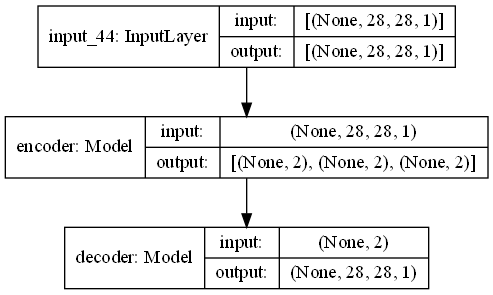

In [164]:
## Chain together to get VAE
i = encoder.inputs
if len(i) == 1:
 i = i[0]
 pass
z = encoder(i)[2]
o = decoder(z)

# Construct and show the VAE model
vae = Model(i, o, name='VAE')
vae.summary()
plot_model(vae,show_shapes = True)

# Compile and train the VAE model (3 marks)

The `compile_vae` methods compiles the VAE model passed as the sole argument. The method computes

1. the image reconstruction loss (`reco_loss`), as well as
2. the Kullback-Leibler (KL) loss (`kl_loss`) for the latent space p.d.f.

The first loss measures how well the VAE is doing at reconstructing the input images; the second loss quantifies how continuous the latent representation is. The two losses are then summed (and added as separate metrics for monitoring), and the VAE model is compiled with the Adam optimiser.

In [165]:
def compile_vae (vae):

    # Get the latent p.d.f. mean and log-variance output layers from VAE encoder
    encoder   = vae.get_layer('encoder')
    z_log_var = encoder.get_layer('z_log_var').output
    z_mean    = encoder.get_layer('z_mean').output

    # Define reconstruction loss
    def reco_loss (y_true, y_pred):
        # Use binary cross-entropy loss
        reco_loss_value = binary_crossentropy(y_true, y_pred) # Averages over axis=-1
        reco_loss_value = K.sum(reco_loss_value, axis=(1,2))
        return reco_loss_value

    # Define Kullback-Leibler loss with reference to encoder output layers
    def kl_loss (y_true, y_pred):
        kl_loss_value = 0.5 * (K.square(z_mean) + K.exp(z_log_var) - 1. - z_log_var)
        kl_loss_value = K.sum(kl_loss_value, axis=-1)
        return kl_loss_value

    # Define VAE loss
    def vae_loss (y_true, y_pred):
        return reco_loss(y_true, y_pred) + kl_loss(y_true, y_pred)

    vae.compile(optimizer='adam', loss=vae_loss, metrics=[reco_loss, kl_loss])
    return

#### 4. Construct, compile, and train a VAE using the methods provided above (1 mark)

* Call the model `vae`, and use **2 latent dimensions.**
* Display the model using the `plot_model(vae, show_shapes=True)` method, to validate that it looks as expected.
* Compile the model.
* Train for ca. **50 epochs**, using the testing dataset for validation.
* Plot the all of the loss histories in `vae.history.history`. Use a suitable fraction of training data for validation

In [166]:
# Define parameters
latent_dim =  2
nb_epochs  =  50
batch_size = 128

# Call the vae model, not really sure what its asking for with 2 latent dimensions
call = compile_vae(vae)

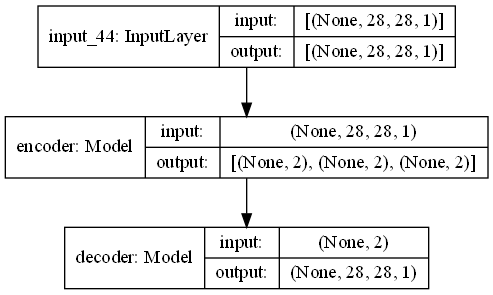

In [167]:
# Plot model
plot_model(vae, show_shapes=True)

<span style="color:blue">
    This is the expected shape I believe. The encoder outputs 3 values, but you only use 1. I think this is correct.
</span>

In [168]:
# Fit the model. Decrease batch size for slower but better results.
# Another way to improve results is allow for more nodes in convoluted layers. But the runtime would be too long to be
# run on the university computers again. Not a good use of time.
vaefit = vae.fit(X_train, X_train, epochs = 50, batch_size = 256, validation_data = (X_test,X_test), shuffle = True)

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 25s 409us/sample - loss: 230.6514 - reco_loss: 227.6952 - kl_loss: 2.9562 - val_loss: 183.8610 - val_reco_loss: 179.8130 - val_kl_loss: 4.0480
Epoch 2/50
60000/60000 [==============================] - 24s 398us/sample - loss: 178.3966 - reco_loss: 174.1861 - kl_loss: 4.2106 - val_loss: 175.0992 - val_reco_loss: 170.5664 - val_kl_loss: 4.5329
Epoch 3/50
60000/60000 [==============================] - 24s 401us/sample - loss: 172.2521 - reco_loss: 167.7029 - kl_loss: 4.5492 - val_loss: 170.8288 - val_reco_loss: 166.0702 - val_kl_loss: 4.7587
Epoch 4/50
60000/60000 [==============================] - 24s 405us/sample - loss: 168.5236 - reco_loss: 163.7118 - kl_loss: 4.8118 - val_loss: 168.2761 - val_reco_loss: 163.3537 - val_kl_loss: 4.9224
Epoch 5/50
60000/60000 [==============================] - 24s 406us/sample - loss: 164.8484 - reco_loss: 159.7930 - kl_loss: 5.0554 - val_loss: 16

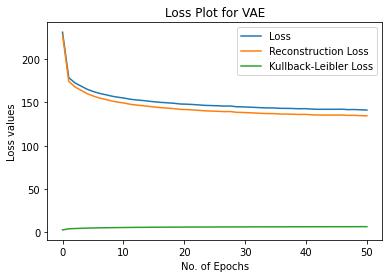

In [169]:
epochs = np.linspace(0,50,50)
plt.xlabel("No. of Epochs")
plt.ylabel("Loss values")
plt.title("Loss Plot for VAE")
plt.plot(epochs,vaefit.history['loss'], label = 'Loss')
plt.plot(epochs,vaefit.history['reco_loss'], label = 'Reconstruction Loss')
plt.plot(epochs,vaefit.history['kl_loss'], label = 'Kullback-Leibler Loss')
plt.legend()
plt.show()

<span style="color:blue">
    Not a good loss plot, will have to ask about this tomorrow.
</span>

#### 5. Predict the test digits into the 2D laten space (1 mark)

- Use the encoder to predict images into the laten space
- Make a scatter plot per digit (use masking, see our first ML Lecture 2) and include a legend
- Include a grid.
- Discuss the results. Why do you think some digits overlap, and why are some clearly seperated? 

In [173]:
# predicting images into the laten space
laten_pred = encoder.predict(X_test)

In [231]:
print(len(laten_pred), laten_pred[0].shape, laten_pred[1].shape, laten_pred[2].shape)
# laten_pred spits out a list of 3
# each has (10000, 2) array. These are for z_mean, z_log_var and z
# We'll look at z_mean, which is laten_pred[0]

# Gives XY
print(laten_pred[0][0])


print(y_test.shape)

3 (10000, 2) (10000, 2) (10000, 2)
[-1.2655022 -1.6540616]
(10000,)


C:\Users\John\anaconda3\envs\daml\lib\site-packages\ipykernel_launcher.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


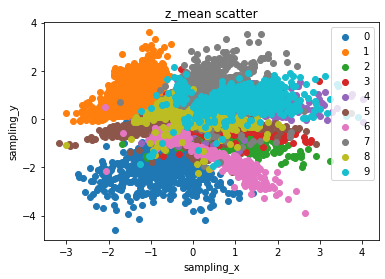

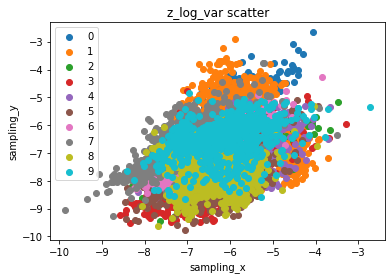

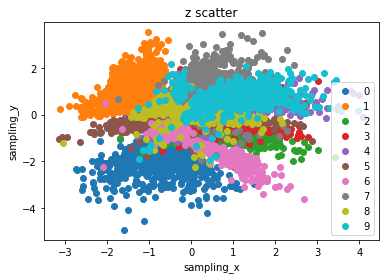

In [253]:
# Create scatter plot

# features to plot. From sampling which is what forms z. Need to ask, what this is about.
featx = 'sampling_x'
featy = 'sampling_y'
title = ['z_mean scatter', 'z_log_var scatter', 'z scatter']

# Set up empty array
new_laten = []

# Create figure and axis objects


for l in range(len(laten_pred)):
    
    fig, ax = plt.subplots()
    for i in range(nb_classes):
        # Mask - makes true or false dependent on label. So all 0's are true everything else false, then for 1's, 2's, etc.
        mask = y_test == i

        # Create array for which only mask elements of z_mean are saved
        new_laten_pred = laten_pred[l][mask]
        # Plot these elements on a scatter, with equivalent label for the class
        ax.scatter([x[0] for x in new_laten_pred],[x[1] for x in new_laten_pred], label = i)

    ax.set_title(title[l])
    ax.legend()
    ax.set_xlabel(featx)
    ax.set_ylabel(featy)    
    fig.show()            


In [170]:
# Autoencoder predicting the X_test (digit) images
digit_pred = vae.predict(X_test)

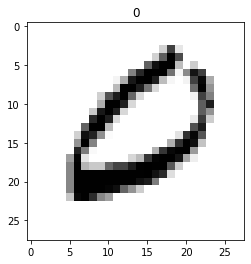

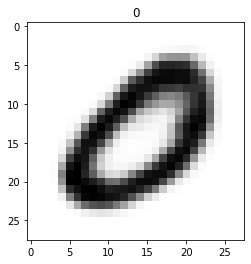

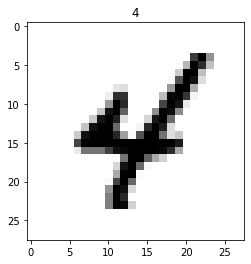

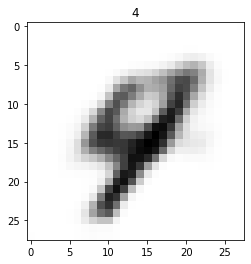

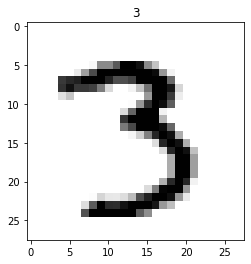

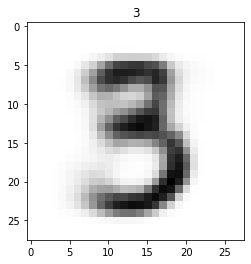

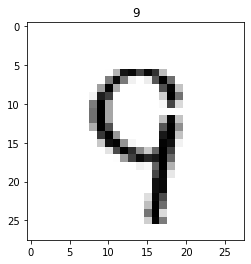

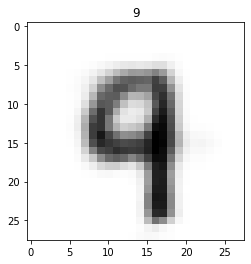

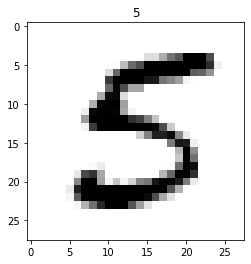

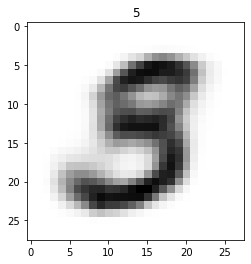

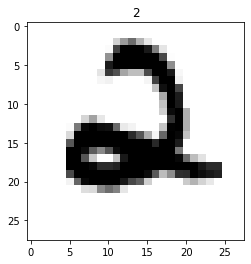

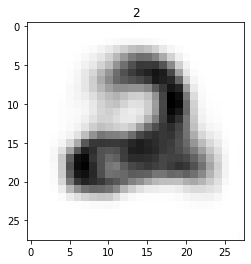

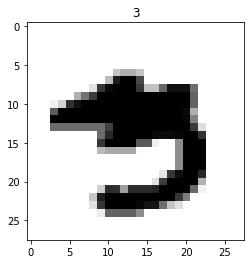

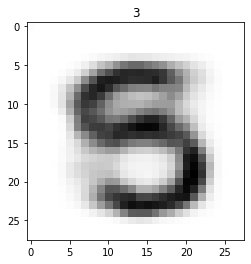

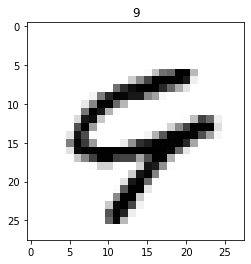

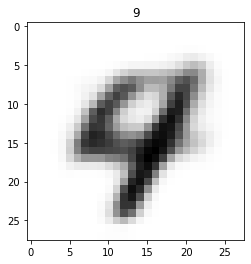

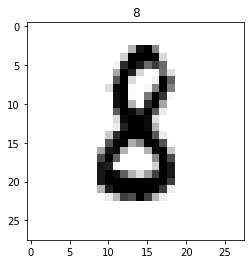

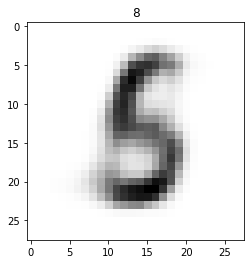

In [172]:
# Plot predictions, just for curiosity.
for i in range(9):
    # Shows true image
    plt.imshow(X_test[i],cmap=plt.cm.binary)
    # Collects its correct label
    plt.title(int(y_test[i]))
    plt.show()
    
    # Show reproduced image
    plt.imshow(digit_pred[i], cmap=plt.cm.binary)
    plt.title(int(y_test[i]))
    plt.show()

#### 6. Generate samples across the latent space of the VAE (2 marks)

* Define an equally-spaced set of $\boldsymbol{N \approx 10}$ **points** along each of the two latent dimensions, that you want to sample (_e.g._ using the `np.linspace` method in the range $(-2,2)$). You can play around with this range in order to focus on areas you personally think might be interesting (look at your grid plot above).
* Convert these into a grid of pairs of coordinates using the `np.meshgrid` method.
* Define an $(N^{2}, 2)$ array, and fill it with all of these pairs of latent space coordinates (you'll need to `flatten` the two outputs from `np.meshgrid`).
* Get the decoder predictions (_i.e._ the generated images) for this set of $N^{2}$ coordinates in the latent space.
* Display them in a grid, _e.g._ using the `plt.imshow` method.
* Discuss the results.

_Indicative answer:_ This figure shows us that:
        
Using VAEs, we're able to generate new images that look like the original ones. That's a pretty big thing, and something we couldn't do with a standard (non-variational) auto-encoder.


# Generative Adversarial networks (2 marks)

Putting together a GAN by yourself is a big task and outside the scope of what we can cover.

Instead here we provide the building blocks for creating the GAN on the MNIST dataset. Your task is to go through individual components and show your understanding. The source material can be found [here](https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-an-mnist-handwritten-digits-from-scratch-in-keras/) with ample explenations, so think of it as a short literature review, the point being to get you to engage with the material.


**Suggestion**: you could choose to answer the question in the same markdown block they are asked. Make the answer distiguishable by for example using a seperator by typing `---` on a new line.



#### 7. Discuss components of generative adverserial NN (0.5 marks)




In [45]:
# all imports needed from here
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from tensorflow.python.keras.datasets.mnist import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Reshape
from tensorflow.python.keras.layers import Flatten
from tensorflow.python.keras.layers import Conv2D
from tensorflow.python.keras.layers import Conv2DTranspose
from tensorflow.python.keras.layers import LeakyReLU
from tensorflow.python.keras.layers import Dropout
from matplotlib import pyplot
 

---

- Defined is the discriminator model using the `Sequential` keras function
    - What is the purpose of the discriminator?
    - Discuss the structure. What are the LeakyReLU and Dropout layers?
    - Why is binary crossentropy used as the loss function?

In [46]:
# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):
	model = Sequential()
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Flatten())
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3136)             

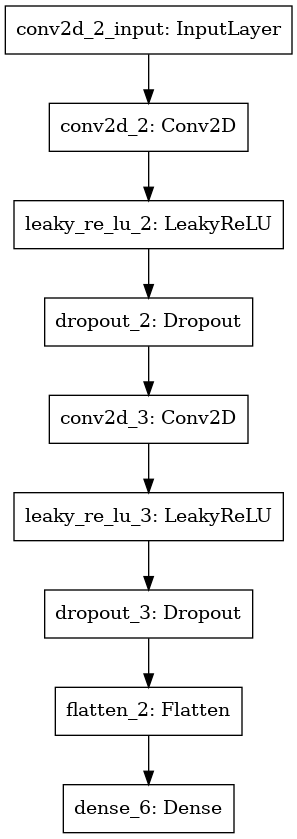

In [49]:
# create the discriminator
d_model = define_discriminator()
d_model.summary()
plot_model(d_model)

---
- Defined is the generator model
    - What is used as input to the generative model?
    - What is the Conv2DTranspose layer used for?
    - Why is sigmoid used as the activation function?

In [51]:
# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((7, 7, 128)))
	# upsample to 14x14
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 28x28
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
	return model
 

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 128)       262272    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 28, 28, 128)      

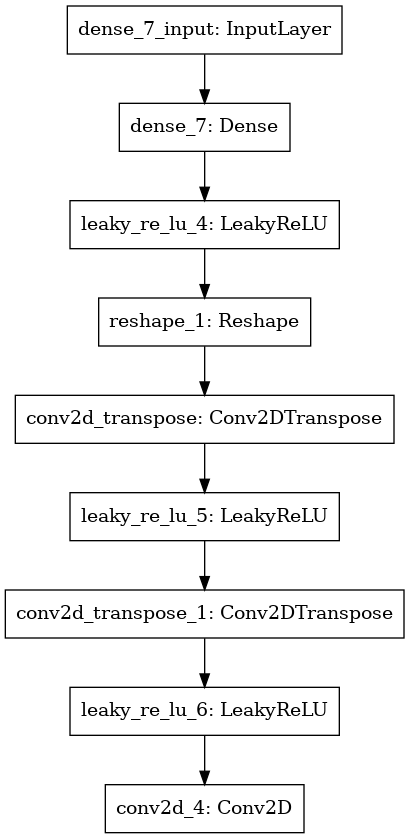

In [54]:
# size of the latent space
latent_dim = 100
# create the generator
g_model = define_generator(latent_dim)
g_model.summary()
plot_model(g_model)

---
- We define the GAN model as a sequence of both generator and discriminator
    - Explain the order of the sequence, and the flow of input to output, through the generator and discriminator
    - Notice the discriminator is not trainable in the gan model. Can you think of why that might be? This may become clear when we discuss the training loop.

In [55]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model
 

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 28, 28, 1)         1164289   
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 40705     
Total params: 1,204,994
Trainable params: 1,164,289
Non-trainable params: 40,705
_________________________________________________________________


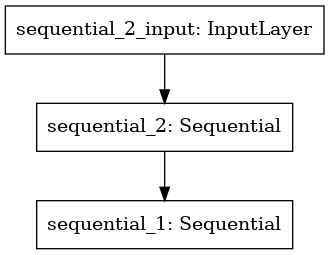

In [57]:
# create the gan
gan_model = define_gan(g_model, d_model)
gan_model.summary()
plot_model(gan_model)

---
##### 8. Discuss the training datasets (0.5 marks)

- Given are real mnist datasets. 
- `load_real_samples` prepares mnist
- `generate_real_samples` allows us to select a subset of data for barch training
    - what is this data used for?
    - what is the `y = ones((n_samples, 1))` varible used for?

In [ ]:
# load and prepare mnist training images
def load_real_samples():
	# load mnist dataset
	(trainX, _), (_, _) = load_data()
	# expand to 3d, e.g. add channels dimension
	X = expand_dims(trainX, axis=-1)
	# convert from unsigned ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [0,1]
	X = X / 255.0
	return X
 
# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	y = ones((n_samples, 1))
	return X, y
 

---
- Given are functions to generate random numbers from laten space
    - use `generate_fake_samples` to create a single random image propegated through the generator. Discuss the result.

In [58]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

---
Some functions for saving GAN models and output images

In [69]:
# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, epoch, n=10):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()
# evaluate the discriminator, plot generated images, save generator model

def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# save the generator model tile file
	filename = 'generator_model_%03d.h5' % (epoch + 1)
	g_model.save(filename) 

#### 9 Training the GANs (1 marks)

The GAN training sequnce is done in batches of data per epoch. Because the generator weights cannot be updated in the standard way, this is done iteratively in a loop. 


- Discuss the lines within the `j` loop. Explain how the generator and discriminator are trained in this context. 

In [70]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=5, n_batch=256):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# create training set for the discriminator
			X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
			# update discriminator model weights
			d_loss, _ = d_model.train_on_batch(X, y)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
		# evaluate the model performance, sometimes
		if (i+1) % 2 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim)
 

- Train the GAN model. 
    - This takes a very long time, so I would recommend aiming for 3 epochs and checking the figures that are generated (saved locally). They won't be good, but you will get some idea already that we don't have random noise
    - Discuss the print out. How do the loss functions change over time?
    - Generate some images with your new number generator and plot them. 
    - Feel free to try for more epoches (if you insist!). If you have some hours to waste, 10 should start showing some good digits, and by 50 you should get some good results.

In [ ]:
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim,epochs=1)